# **The MNIST dataset is often being referred to as the "Hello World!" of Machine Learning**

**In this kernel I have demonstrated how to step by step design a model to tackle the MNIST challenge**

A special regard to Francis Chollet (Author of Keras) for writing an amazing book, "Deep Learning with Python".

Let us begin!

I have used the following techniques which will get you a step by step increment on the test set accuracy

**1. Random Forest Algorithm (93.5% on the Test set)**

> A limited parameter (max_depth = 20) ensemble of only 20 Decision Trees (default value is 100) which prevents overfitting and provides satisfactory accuracy on the validation set (around 95%) 

**2. A Simple Convolutional Neural Network (98.5% on the Test set)**

> A simple CNN with minimal parameters. No advanced techniques like Batch Normalization, Learning Rate Annealer, or Data Augmentation. The validation accuracy will be around 99.1% (see previous versions of the kernel)

**3. CNN with Data Augmentation (99.35% on the Test set)**

> Apply Data Augmentation on the CNN along with learning rate annealer and Nadam optimizer. The validation accuracy will be around 99.48% at 20 epochs

**4. An ensemble of CNNs (99.67% on the Test set)**

> Combine 7 previously designed CNNs to work on random shuffled subsets of training and validation data. The ensemble technique used is Bagging. The validation accuracy achieved is 99.55%. To touch the test set accuracy mark of 99.7% you just have to increase the number of CNNs in the ensemble

**5. We can use some regularization techniques to achieve 99.7% which seems to be accepted limit for the competition**

> Increase the number of CNNs in the ensemble to 10 and apply regularization techniques to achive 99.7%. One can also aggregate the predictions of 5 different CNN architectures instead of using multiple same CNN implementations.

**6. We have used multiple ML and DL algorithms & techniques to continuously increase our test set accuracy. Some more architectures can be experimented with, to touch the golden mark of 99.7%. But the problem is you still would not win the competition. Because some kagglers have been cheating to get a perfect test score of 100%.**

**I first read about this in Aurelion Geron's book "Hands on ML". The book mentions this article to elaborate on how someone can achive a perfect 100% accuracy on the test set. **

https://www.kaggle.com/c/digit-recognizer/discussion/61480

> **So how can you cheat and hit the bullseye**
> 
> **Train a model on the entire MNIST dataset (70K images) and then use it to make predictions**
> 
> **A lot of notebooks use an ensemble CNN or simple CNN with the full MNIST dataset for a perfect score.**
> 
> **But wait! If cheating is what you want to do, maybe do it the smart way. Simply use a Decision Tree Algorithm with (max_depth = None). It is in the nature of Decision Trees to overfit the training data.**

In [1]:
# Importing the libraries

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau

from tensorflow import keras  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


In [2]:
# Importing the training dataset

dataset = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
dataset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Inspecting the dataset

dataset.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [4]:
# Checking for missing values

np.any(dataset.isnull().sum())

False

In [5]:
# Slicing the dataset to separate feature matrix 'X' and the vector of predictions 'y'

X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

X.shape, y.shape, X.dtype, y.dtype

((42000, 784), (42000,), dtype('int64'), dtype('int64'))

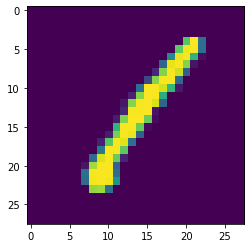

In [6]:
# Visualizing the dataset by reshaping an image into the original format i.e. 28 * 28

first_image = X[0]
first_image = first_image.reshape((28, 28))

plt.imshow(first_image)
plt.show()

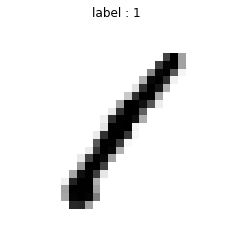

In [7]:
# Grayscaling the image, dropping the axis and printing the label

plt.imshow(first_image, "binary")
plt.title('label : {}'.format(y[0]))
plt.axis('off')
plt.show()

Random Indexes :  [ 7970 25382 25523 27905 32299 41477  9456 29678   582 14865 22359 20376
  5137 34053 12308  8301 22530 14140 37688 29630 29062 11313 36870  9246
 39063]

 Shape :  (25, 784)


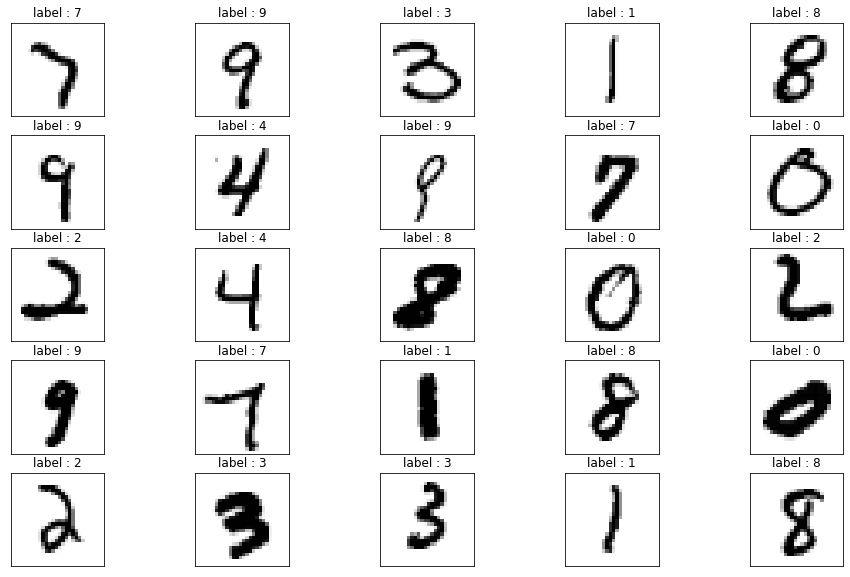

In [8]:
# Plotting multiple randomly chosen images from the dataset for insights

random_indexes = np.random.choice(range(len(X)), 25)
print("Random Indexes : ", random_indexes)

X_random = X[random_indexes]
y_random = y[random_indexes]

print("\n Shape : ", X_random.shape)

plt.figure(figsize = (16, 10))
for i in range(25):
    image = X_random[i]
    image = image.reshape((28, 28))
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, "binary")
    plt.title('label : {}'.format(y_random[i]))
plt.show()

In [9]:
# Applying feature scaling for faster convergence

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
# Importing the test set

test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
X_test = test_data.values
X_test.shape

(28000, 784)

In [11]:
# Scaling the test set

X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
# Reshaping the data for Image Generator (Rank = 4)

X = X.reshape((42000, 28, 28, 1))

In [13]:
# Applying Data Augmentation

datagen = ImageDataGenerator(rotation_range=10,  zoom_range = 0.1,  width_shift_range=0.1,  height_shift_range=0.1)
# datagen.fit(X)

In [14]:
# An empty list to store the ensemble of 10 CNNs

model_list = []

In [15]:
# Learning rate annealer

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-6)

In [16]:
# Creating 7 objects of the same CNN architecture and saving in model_list

for i in range(7):
    model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = [28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', padding = 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation = 'softmax')])

    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])
    model_list.append(model)



In [17]:
# Verifying the hashcodes

model_list

In [18]:
# Reshaping to a tensor of rank 4

# X = X.reshape((42000, 28, 28, 1))
X.shape

(42000, 28, 28, 1)

In [19]:
# Training all the 7 CNNs in the ensemble together

history = [0] * 7

for i in range(7):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.08)
    history[i] = model_list[i].fit_generator(datagen.flow(X, y, batch_size = 64), 
                                             epochs = 20, validation_data = (X_valid, y_valid), callbacks = [reduce_lr])
    print("CNN : {} Maximum Train Accuracy : {} Maximum Validation Accuracy : {}".format(i+1, max(history[i].history['accuracy']), max(history[i].history['val_accuracy'])))

Train for 657 steps, validate on 3360 samples
Epoch 1/20
657/657 [==============================] - 23s 35ms/step - loss: 0.4326 - accuracy: 0.8690 - val_loss: 0.0672 - val_accuracy: 0.9777
Epoch 2/20
657/657 [==============================] - 18s 27ms/step - loss: 0.1488 - accuracy: 0.9566 - val_loss: 0.0464 - val_accuracy: 0.9827
Epoch 3/20
657/657 [==============================] - 18s 27ms/step - loss: 0.1100 - accuracy: 0.9677 - val_loss: 0.0268 - val_accuracy: 0.9920
Epoch 4/20
657/657 [==============================] - 18s 27ms/step - loss: 0.0906 - accuracy: 0.9738 - val_loss: 0.0305 - val_accuracy: 0.9911
Epoch 5/20
657/657 [==============================] - 17s 26ms/step - loss: 0.0793 - accuracy: 0.9771 - val_loss: 0.0516 - val_accuracy: 0.9866
Epoch 6/20
655/657 [============================>.] - ETA: 0s - loss: 0.0725 - accuracy: 0.9791
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
657/657 [==============================] - 17s 26ms/step 

In [20]:
# Creating a prediction tensor for applying the bagging technique

ensemble_cnn_pred = np.zeros((X_test.shape[0], 10))
ensemble_cnn_pred.shape

(28000, 10)

In [21]:
# Reshaping the test set in a Rank 4 tensor

X_test_scaled = X_test_scaled.reshape((28000, 28, 28, 1))
X_test_scaled.shape

(28000, 28, 28, 1)

In [22]:
# Generating and aggregating predictions

for i in range(7):
  ensemble_cnn_pred = ensemble_cnn_pred + model_list[i].predict(X_test_scaled)

In [23]:
# Verifying the predictions of the ensemble

np.sum(ensemble_cnn_pred[0])

7.000000002387869

In [24]:
# Aggregating the predictions

ensemble_cnn_pred = np.argmax(ensemble_cnn_pred, axis = 1)
ensemble_cnn_pred[0]

2

In [25]:
# Verifying the shape

ensemble_cnn_pred.shape

(28000,)

In [26]:
# Saving the predictions in a dataframe

pred_df_ensemble_cnn = pd.DataFrame(columns = ['ImageId', 'Label'])
pred_df_ensemble_cnn['ImageId'] = np.arange(1, 28001)
pred_df_ensemble_cnn['Label'] = ensemble_cnn_pred
pred_df_ensemble_cnn

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [27]:
# Writing the predictions in a csv file

pred_df_ensemble_cnn.to_csv('ens_cnn_with_aug_sub.csv', index = False)

> I sincerely hope you found something useful by reading this kernel!
> 
> Happy Kaggling!